In [637]:
import os
os.chdir('/Users/philippratz/Documents/Uni/PhD/UQAM/courses/RL/mcgill_precup/project/')

import numpy as np
import pandas as pd
import random
from collections import namedtuple, deque
from copy import deepcopy


# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
%load_ext pycodestyle_magic
%load_ext autoreload

In [3]:
from main.environment.simple_environment import SimpleEconEnvironment

In [1]:
class BaseMLP(nn.Module):
    def __init__(self, arch,
                 input_size=2,
                 output_size = 1,
                 dropout=0.1, 
                 output_function=None):
        super().__init__()
        self.output_size = output_size
        self.input_size = input_size
        self.layers = nn.ModuleList()
        self.dropout = nn.Dropout(dropout)
        self._set_arch(arch, input_size)
        self.output_function = output_function
        
    def _set_arch(self, arch, input_size):
        current_size = input_size
        for lay_size in arch:
            self.layers.append(nn.Linear(current_size, lay_size))
            current_size = lay_size
            
        self.final_layer = nn.Linear(current_size, self.output_size)

    def forward(self, x):
        for lay_ in self.layers:
            x = F.relu(lay_(x))
            x = self.dropout(x)
            
        x = self.final_layer(x)

        if self.output_function is not None:
            x = self.output_function(x)
        
        return x
    
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
def init_weights(lay):
    if isinstance(lay, nn.Linear):
        torch.nn.init.xavier_normal_(lay.weight)
        lay.bias.data.fill_(1.0)
    

def train_model(replay_buffer,
                model,
                target_model,
                optimizer,
                batch_size=128, 
                gamma=0.99):

    trans_sample = replay_buffer.sample(batch_size)
    batch = Transition(*zip(*trans_sample))

    sample_state = torch.cat(batch.state)
    sample_reward = torch.cat(batch.reward)
    sample_action = torch.cat(batch.action)
    sample_next_state = torch.cat(batch.next_state)

    # cast to avoid issues with torch
    sample_state = sample_state.type(torch.FloatTensor)
    sample_next_state = sample_next_state.type(torch.FloatTensor)

    q_values_hat = model(sample_state).gather(1,sample_action)

    # No grad here as we do not optimize target net
    target_model.eval()
    with torch.no_grad():
        next_q_val, _ = target_model(sample_next_state).max(1)
    target_model.train()
    
    target_value = sample_reward.squeeze() + gamma* next_q_val
    
    criterion = nn.SmoothL1Loss()
    loss = criterion(q_values_hat.squeeze(), target_value)

    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(model.parameters(), 100)
    optimizer.step()


def soft_update_nets(model, target_model, tau):
    target_states = target_model.state_dict()
    model_states = model.state_dict()

    for key in model_states:
        target_states[key] = tau*model_states[key] + (1-tau)*target_states[key]
    target_model.load_state_dict(target_states)

NameError: name 'nn' is not defined

In [664]:
mod_1(sample_states)

tensor([[0.8255],
        [0.9581],
        [0.7071],
        [0.8343],
        [0.8472],
        [0.8622],
        [0.5387],
        [0.7423],
        [0.8512],
        [0.7458]], grad_fn=<AddmmBackward0>)

In [584]:
class DDPG_Actor:
    def __init__(self,
                 all_models,
                 memory_buffer,
                 lr=0.05,
                 lr_critic=0.0125,
                 tau=0.005, 
                 batch_size=64,
                 gamma=0.95):
        
        self.critic = all_models['critic']
        self.critic.apply(init_weights)
        self.target_critic = all_models['critic']

        self.actor = all_models['actor']
        self.actor.apply(init_weights)
        self.target_actor = all_models['actor']

        for target_param, param in zip(self.target_critic.parameters(),
                                       self.critic.parameters()):
            target_param.data.copy_(param.data)
        for target_param, param in zip(self.target_actor.parameters(),
                                       self.actor.parameters()):
            target_param.data.copy_(param.data)

        self.actor_optimizer = optim.Adam(
            self.actor.parameters(),
            lr=lr)

        self.critic_optimizer = optim.Adam(
            self.critic.parameters(), 
            lr=lr_critic)

        self.memory = memory_buffer
        self.batch_size = batch_size
        self.gamma = np.float32(gamma)
        self.tau = tau

        
    def init_weights(self, lay):
        if isinstance(lay, nn.Linear):
            torch.nn.init.xavier_normal_(lay.weight)
            lay.bias.data.fill_(1.0)

    def sample_action(self, state):
        action = self.actor(state)
        return action.detach().numpy()
    
    def soft_update_nets(self, model, target_model, tau):
            target_states = target_model.state_dict()
            model_states = model.state_dict()

            for key in model_states:
                target_states[key] = tau*model_states[key] + (1-tau)*target_states[key]
            target_model.load_state_dict(target_states)
    
    def update(self):
        if len(self.memory) < self.batch_size:
            return
        
        trans_sample = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*trans_sample))

        state = torch.cat(batch.state)
        reward = torch.cat(batch.reward)
        action = torch.cat(batch.action)
        next_state = torch.cat(batch.next_state)

        # cast to avoid issues with torch
        action = action.type(torch.float32)
        state = state.type(torch.float32)
        next_state = next_state.type(torch.float32)

        target_action = self.target_actor(next_state)
        target_critic_values = self.target_critic(torch.cat((next_state, target_action), 1))

        critic_value = self.critic(torch.cat((next_state, action), 1))
        target = (reward.reshape(-1,) + self.gamma * target_critic_values.reshape(-1,)).type(torch.float32).reshape(-1,1)

        # print(reward)
        # print(target_critic_values)

        # print(target)
        # print(reward.shape)
        # print(self.gamma)
        # print(target_critic_values.shape)

        # print(reward.type)
        # print(target_critic_values.type)


        critic_loss_fct = nn.MSELoss()
        critic_loss = critic_loss_fct(critic_value, target)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Now for the others
        policy_actions = self.actor(state)
        actor_loss = -self.critic(torch.cat((state, policy_actions), 1))
        actor_loss = actor_loss.mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft updates
        self.soft_update_nets(self.critic, self.target_critic, self.tau)
        self.soft_update_nets(self.actor, self.target_actor, self.tau)


        # for target_param, param in zip(self.target_critic.parameters(),
        #                                self.critic.parameters()):
        #     target_param.data.copy_(
        #         target_param.data * (1.0 - self.tau) +
        #         param.data * self.tau
        #     )
        # for target_param, param in zip(self.target_actor.parameters(),
        #                                self.actor.parameters()):
        #     target_param.data.copy_(
        #         target_param.data * (1.0 - self.tau) +
        #         param.data * self.tau
        #     )


        # actor_loss = self.critic(state, self.actor(state))
        # actor_loss = -actor_loss.mean()

        # next_action = self.target_actor(next_state)
        # target_value = self.target_critic(next_state, next_action.detach())

        # # 这里的expected_value就是伪代码中间的y_i  
        
        # expected_value = (reward.squeeze() + self.gamma * target_value.squeeze()).reshape(-1,1)
        # expected_value = torch.clamp(expected_value, 0, 15)
        
        # actual_value = self.critic(state, action)
        # critic_loss_fct = nn.SmoothL1Loss()
        
        # actual_value = actual_value.type(torch.float32)
        # expected_value = expected_value.type(torch.float32)

        # critic_loss = critic_loss_fct(actual_value, expected_value.detach())
        # critic_loss = critic_loss.type(torch.float32)
        
        # self.actor_optimizer.zero_grad()
        # actor_loss.backward()
        # self.actor_optimizer.step()
        # self.critic_optimizer.zero_grad()
        # critic_loss.backward()
        # self.critic_optimizer.step()
        # for target_param, param in zip(self.target_critic.parameters(),
        #                                self.critic.parameters()):
        #     target_param.data.copy_(
        #         target_param.data * (1.0 - self.tau) +
        #         param.data * self.tau
        #     )
        # for target_param, param in zip(self.target_actor.parameters(),
        #                                self.actor.parameters()):
        #     target_param.data.copy_(
        #         target_param.data * (1.0 - self.tau) +
        #         param.data * self.tau
        #     )

In [576]:
class BaseMLP(nn.Module):
    def __init__(self,
                 arch,
                 input_size=2,
                 output_size = 1,
                 dropout=0.1, 
                 positive=False):
        super().__init__()
        self.output_size = output_size
        self.input_size = input_size
        self.layers = nn.ModuleList()
        self.dropout = nn.Dropout(dropout)
        self.positive = positive
        self._set_arch(arch, input_size)
        
    def _set_arch(self, arch, input_size):
        current_size = input_size
        for lay_size in arch:
            self.layers.append(nn.Linear(current_size, lay_size))
            current_size = lay_size
            
        self.final_layer = nn.Linear(current_size, self.output_size)

    def forward(self, x):
        for lay_ in self.layers:
            x = F.relu(lay_(x))
            x = self.dropout(x)
            
        x = self.final_layer(x)



        # if self.positive:
        #     x = F.relu(x)        
        
        return x

In [585]:
def train(env, agents, num_trials):
    print("开始训练！")
    ou_noise = OUNoise()  # 动作噪声
    ou_noise_1 = OUNoise()
    rewards_1 = [] # 记录所有回合的奖励
    rewards_2 = []
    ou_noise.reset()
    ou_noise_1.reset()

    state = torch.tensor(np.random.uniform(low=1.47,
                                           high=2,
                                           size=(2,)),
                            dtype=torch.float32).reshape(1,2)

    for i_step in range(num_trials):
        # if i_step % 10000 == 0:
        #     try:
        #         print(action_1, action_2)
        #     except UnboundLocalError:
        #         pass            
        
        # action_1 = agents[0].sample_action(state)
        # action_1 = action_1[0][0]
        # action_1 = action_1 + np.random.normal(scale=0.2)
        
        # #action_1 = np.max([1.47,action_1])

        # action_2 = agents[1].sample_action(state)
        # #action_2 = action_2 + np.random.gamma(shape=0.5*np.exp(-i_step*0.0001))#ou_noise.get_action(action_1, i_step+1) 
        # action_2 = action_2[0][0]
        # action_2 = action_2 + np.random.normal(scale=0.2)
        # #action_2 = np.max([1.47,action_2])

        # # print(action_1)
        # # print(action_2)
        # if np.isnan(action_1):
        #     print(action_1)
        #     print(state)

        # price_tensor = torch.tensor([action_1, action_2],
        #                             dtype=torch.float32).reshape(1,-1)

        # d1, d2 = env(action_1, action_2)
        
        # reward_a1 = torch.tensor((action_1 - 1)*d1).reshape(1,-1)
        # reward_a2 = torch.tensor((action_2 - 1)*d2).reshape(1,-1)

        # # print(reward_a1)
        # # print(reward_a2)

        # next_state = price_tensor

        # agents[0].memory.push(state, torch.tensor(action_1, dtype=torch.float32).reshape(1,1),
        #                       next_state, reward_a1)
        # agents[1].memory.push(state, torch.tensor(action_2, dtype=torch.float32).reshape(1,1),
        #                       next_state, reward_a2)

        agents[0].update()
        agents[1].update()

        

        # state = next_state

        # rewards_1.append(float(reward_a1.detach().numpy()))
        # rewards_2.append(float(reward_a2.detach().numpy()))

    return rewards_1, rewards_2

In [612]:
import pickle
with open('data/buffers/buf_1.pkl', 'rb') as con_:
    buf_1 = pickle.load(con_)

with open('data/buffers/buf_2.pkl', 'rb') as con_:
    buf_2  = pickle.load(con_)

In [613]:
models_1 = {'actor':  BaseMLP([15,15,15], positive=True), 
            'critic': BaseMLP([15,15,15], input_size=3, positive=True)}

models_2 = {'actor':  BaseMLP([15,15,15], positive=True), 
            'critic': BaseMLP([15,15,15], input_size=3, positive=True)}

#replay_1 = ReplayMemory(1000)
actor_1 = DDPG_Actor(models_1, buf_1)

#replay_2 = ReplayMemory(1000)
actor_2 = DDPG_Actor(models_2, buf_2)

envir = SimpleEconEnvironment()

In [638]:
mod_1 = BaseMLP([15,15,15], positive=True)

In [659]:
mod_1.apply(init_weights)

BaseMLP(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=15, bias=True)
    (1-2): 2 x Linear(in_features=15, out_features=15, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (final_layer): Linear(in_features=15, out_features=1, bias=True)
)

In [663]:
with torch.no_grad():
    mod_1.eval()
    print(mod_1(sample_states))

tensor([[0.8255],
        [0.9581],
        [0.7071],
        [0.8343],
        [0.8472],
        [0.8622],
        [0.5387],
        [0.7423],
        [0.8512],
        [0.7458]])


In [614]:
train(envir, [actor_1, actor_2], 20000)

开始训练！


([], [])

In [615]:
a = buf_1.sample(30)

In [616]:
batch = Transition(*zip(*a))

In [621]:
a, b = envir(300.3666, 2.51)

In [636]:
with torch.no_grad():
    print(actor_1.target_actor(torch.cat(batch.state)))

tensor([[347.2950],
        [272.0719],
        [250.3665],
        [325.9579],
        [347.2950],
        [347.2950],
        [347.2950],
        [305.2732],
        [240.9516],
        [347.2950],
        [307.3696],
        [347.2950],
        [292.3883],
        [328.6905],
        [245.4599],
        [347.2950],
        [290.8663],
        [347.2950],
        [305.2732],
        [347.2950],
        [292.3883],
        [347.2950],
        [290.8663],
        [347.2950],
        [347.2950],
        [347.2950],
        [ 20.7487],
        [347.2950],
        [347.2950],
        [279.0295]])


In [ ]:
actor_1.actor()

In [554]:
all_a = []
all_b = []
for k in range(5):
    a, b = train(envir, [actor_1, actor_2], 50000)
    all_a.append(a)
    all_b.append(b)

开始训练！


KeyboardInterrupt: 

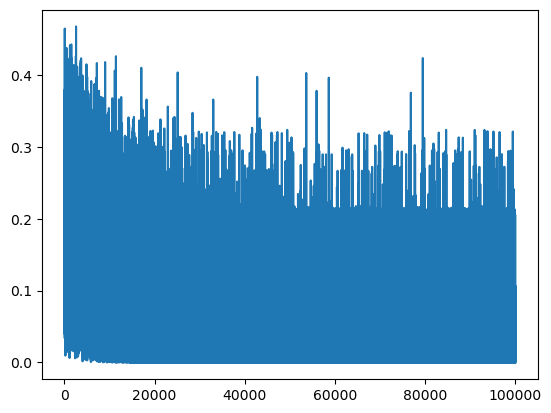

In [530]:
plt.plot(pd.DataFrame(all_a).mean(axis=0))

In [355]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class Actor(nn.Module):
    def __init__(self, n_states, n_actions=1, hidden_dim = 20, init_w=0.01):
        super(Actor, self).__init__()  
        self.linear1 = nn.Linear(n_states, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, n_actions)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        return x
        
class Critic(nn.Module):
    def __init__(self, n_states, n_actions=1, hidden_dim=20, init_w=0.01):
        super(Critic, self).__init__()
        
        self.linear1 = nn.Linear(n_states + n_actions, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        # 随机初始化为较小的值
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        # 按维数1拼接
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [356]:
class OUNoise(object):
    '''Ornstein–Uhlenbeck噪声
    '''
    def __init__(self, action_space=1, mu=0,
                 theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu # OU噪声的参数
        self.theta        = theta # OU噪声的参数
        self.sigma        = max_sigma # OU噪声的参数
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.n_actions   = action_space
        self.low          = 1
        self.high         = 4
        self.reset()
    def reset(self):
        self.obs = np.ones(self.n_actions) * self.mu
    def evolve_obs(self):
        x  = self.obs
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.n_actions)
        self.obs = x + dx
        return self.obs
    def get_action(self, action, t=0):
        ou_obs = self.evolve_obs()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period) # sigma会逐渐衰减
        return np.clip(action + ou_obs, self.low, self.high) # 动作

In [444]:
def train(env, agents, num_trials):
    print("开始训练！")
    ou_noise = OUNoise()  # 动作噪声
    ou_noise_1 = OUNoise()
    rewards_1 = [] # 记录所有回合的奖励
    rewards_2 = []
    ou_noise.reset()
    ou_noise_1.reset()

    state = torch.tensor(np.random.uniform(low=1.47,
                                           high=2,
                                           size=(2,)),
                            dtype=torch.float32).reshape(1,2)

    for i_step in range(num_trials):
        if i_step % 1000 == 0:
            print(i_step)
            try:
                print(action_1, action_2)
            except UnboundLocalError:
                pass

        action_1 = agents[0].sample_action(state)
        #action_1 = action_1 + np.random.gamma(shape=0.5*np.exp(-i_step*0.0001))#ou_noise.get_action(action_1, i_step+1) 
        action_1 = action_1[0][0]
        
        #action_1 = np.max([1.47,action_1])

        action_2 = agents[1].sample_action(state)
        #action_2 = action_2 + np.random.gamma(shape=0.5*np.exp(-i_step*0.0001))#ou_noise.get_action(action_1, i_step+1) 
        action_2 = action_2[0][0]
        #action_2 = np.max([1.47,action_2])

        # print(action_1)
        # print(action_2)

        price_tensor = torch.tensor([action_1, action_2],
                                    dtype=torch.float32).reshape(1,-1)

        d1, d2 = env(action_1, action_2)
        
        reward_a1 = torch.tensor((action_1 - 1)*d1).reshape(1,-1)
        reward_a2 = torch.tensor((action_2 - 1)*d2).reshape(1,-1)

        # print(reward_a1)
        # print(reward_a2)

        next_state = price_tensor

        agents[0].memory.push(state, torch.tensor(action_1, dtype=torch.float32).reshape(1,1),
                              next_state, reward_a1)
        agents[1].memory.push(state, torch.tensor(action_2, dtype=torch.float32).reshape(1,1),
                              next_state, reward_a2)

        agents[0].update()
        agents[1].update()

        state = next_state

        rewards_1.append(float(reward_a1.detach().numpy()))
        rewards_2.append(float(reward_a2.detach().numpy()))

    return rewards_1, rewards_2

In [361]:
def train(env, agents, num_trials):
    print("开始训练！")
    ou_noise = OUNoise()  # 动作噪声
    ou_noise_1 = OUNoise()
    rewards_1 = [] # 记录所有回合的奖励
    rewards_2 = []
    ou_noise.reset()
    ou_noise_1.reset()

    state = torch.tensor(np.random.uniform(low=1.47,
                                           high=2,
                                           size=(2,)),
                            dtype=torch.float32).reshape(1,2)

    for i_step in range(num_trials):
        if i_step % 1000 == 0:
            print(i_step)
            try:
                print(action_1, action_2)
            except UnboundLocalError:
                pass

        action_1 = agents[0].sample_action(state)
        action_1 = action_1 + np.random.gamma(shape=0.5*np.exp(-i_step*0.0001))#ou_noise.get_action(action_1, i_step+1) 
        action_1 = action_1[0][0]
        
        #action_1 = np.max([1.47,action_1])

        action_2 = agents[1].sample_action(state)
        action_2 = action_2 + np.random.gamma(shape=0.5*np.exp(-i_step*0.0001))#ou_noise.get_action(action_1, i_step+1) 
        action_2 = action_2[0][0]
        #action_2 = np.max([1.47,action_2])

        # print(action_1)
        # print(action_2)

        price_tensor = torch.tensor([action_1, action_2],
                                    dtype=torch.float32).reshape(1,-1)

        d1, d2 = env(action_1, action_2)
        
        reward_a1 = torch.tensor((action_1 - 1)*d1).reshape(1,-1)
        reward_a2 = torch.tensor((action_2 - 1)*d2).reshape(1,-1)

        # print(reward_a1)
        # print(reward_a2)

        next_state = price_tensor

        agents[0].memory.push(state, torch.tensor(action_1, dtype=torch.float32).reshape(1,1),
                              next_state, reward_a1)
        agents[1].memory.push(state, torch.tensor(action_2, dtype=torch.float32).reshape(1,1),
                              next_state, reward_a2)

        agents[0].update()
        agents[1].update()

        state = next_state

        rewards_1.append(float(reward_a1.detach().numpy()))
        rewards_2.append(float(reward_a2.detach().numpy()))

    return rewards_1, rewards_2

In [362]:
models_1 = {'actor':  Actor(2), 
            'critic': Critic(2)}

models_2 = {'actor':  Actor(2), 
            'critic': Critic(2)}

replay_1 = ReplayMemory(1000)
actor_1 = DDPG_Actor(models_1, replay_1)

replay_2 = ReplayMemory(1000)
actor_2 = DDPG_Actor(models_2, replay_2)

envir = SimpleEconEnvironment()

In [363]:
all_a = []
all_b = []
for k in range(5):
    a, b = train(envir, [actor_1, actor_2], 20000)
    all_a.append(a)
    all_b.append(b)

开始训练！
0
1000
1.0534246 1.0110514
2000
1.0257945 1.1830912
3000
1.0064166 1.0001221
4000
1.0072434 1.781799
5000
1.7864602 1.0022182
6000
1.83484 1.1512321
7000
1.1235956 1.0002
8000
1.0268321 1.1299069
9000
1.8006325 1.0055082
10000
1.0000006 1.0041665
11000
1.004067 1.001761


KeyboardInterrupt: 

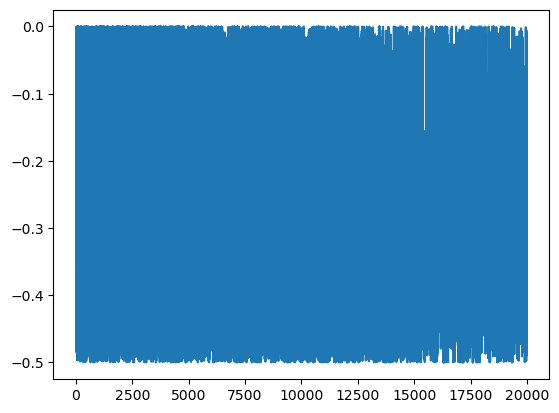

In [360]:
plt.plot(pd.DataFrame(all_b).mean(axis=0))

In [ ]:
def sampling_noise(self, x, theta=THETA, mu=0, dt=DT, std=0.2):
        """
        Ornstein–Uhlenbeck process
        """
        return x + theta * (mu-x) * dt + std * np.sqrt(dt) * np.random.normal(size=self.actions_dim)

def get_action(self, observation, noise, evaluation=False):
    state = tf.convert_to_tensor([observation], dtype=tf.float32)
    actions = self.actor(state)
    if not evaluation:
        self.noise = self._ornstein_uhlenbeck_process(noise)
        actions += self.noise

    actions = tf.clip_by_value(actions, self.lower_bound, self.upper_bound)

    return actions[0]

In [ ]:
def select_action_training(model, state, epsilon, n_actions=15):
     if np.random.uniform() > epsilon:
        model.eval()
        with torch.no_grad():
            _, action_idx = model(state).reshape(1,-1).max(1)

        model.train()
        return action_idx
     else:
        return torch.tensor([random.choices(range(n_actions), k=1)])
    